### Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pylab 
import cmath
import random
from scipy import integrate
from scipy.fftpack import fft
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from scipy import signal
import pandas as pd
import time
import torch.nn as nn
import torch.nn.functional as F
import time 
import visdom

In [4]:
torch.cuda.is_available()

True

### Erzeuge W

Generiere ein paar W aus $L_{2,loc}$ und ihre Ableitungen

In [5]:
x = np.arange(-5,5,0.001)
dx = x[1] - x[0]

In [6]:
def Gauss(mu, sig, x): #Achtung, hier ist x eine Position, nicht das Grid (ist doch eh das selbe?)
    return np.exp(-(x-mu)**2/(2*sig**2))/(2*np.pi*sig**2)

In [7]:
def generate_W(x):
    rate = 0.01 #das brauchen wir garnicht oder?
    ran = np.zeros(len(x))
    asym = int(len(ran)/4)
    for i in range(asym, len(ran) - asym):
        coin = np.random.uniform()
        if coin < 0.3:
            ran[i] = np.random.uniform() / (0.4 *asym)
    con = np.convolve(ran, Gauss(0,0.1,x)) + 1
    a = int(len(x)/2)
    return con[a:a+len(x)]

In [8]:
def diff_W(W):
    dW = np.zeros(len(W))
    dW[:-1] = np.diff(W)/dx
    return dW

### Berechne $n_r$ und $n_i$

In [9]:
k = 10

In [10]:
def n_r(W, dW, x, k):
    n_r = np.zeros(len(x))
    for i in range(len(x)):
        n_r[i] = W[i]/np.sqrt(2)*np.sqrt(1+np.sqrt(1+ dW[i]**2/(W[i]**4*k**2) ))
    return n_r

def n_i(dW, n_r, x, k):
    n_i = np.zeros(len(x))
    for i in range(len(x)):
        n_i[i] = -1/2/k*dW[i]/n_r[i]
    return n_i

def n_compl(W,dW,x,k):
    nr = n_r(W, dW, x, k)
    ni = n_i(dW, nr, x, k)
    n = nr + ni * 1j
    return n

In [11]:
def plot_n(x,W,dW,k):
    #pylab.plot(x,W,label='W')
    #pylab.plot(x,dW,label='dW')
    n = n_compl(W,dW,x,k)
    pylab.plot(x,n.real,label='n_r')
    pylab.plot(x,n.imag,label='n_i')
    pylab.legend(loc='upper left')
    #pylab.title("W = cos(t)")
    pylab.show()

$n_r$ und $n_i$ geplottet sehen dann so aus:

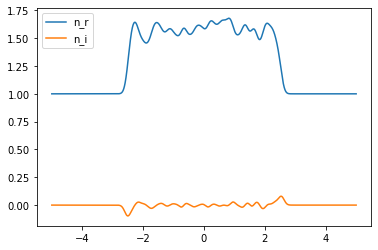

In [12]:
x = np.arange(-5,5,0.001)
dx = x[1] - x[0]

W = generate_W(x)
dW = diff_W(W)

plot_n(x, W, dW,k)

### Berechne aus W und n die Wellenfunktion mit Numerov

$\psi'' + k^2 n^2 \psi = 0$

Der iterative Algorithmus sieht dann so aus:

$s := \frac{h^2 k^2}{12} $

$\psi_{i+2} = \frac{ 2(1 - 5 s n_{i+1}^2)\psi_{i+1} - (1 + s n_{i+1}^2)\psi_{i} }{1 + s n_{i+2}^2}  $

In [13]:
def Numerov(x, dx, n, psi_r0, psi_r1, psi_i0, psi_i1,k):
    
    psi = np.zeros(len(x), dtype=complex)
    psi[0] = complex(psi_r0, psi_i0) #Startwerte
    psi[1] = complex(psi_r1, psi_i1)
    
    s = dx**2/12 * k**2
    
    for i in range(len(x)-2):
                
        psi[i+2] = ( 2*( 1-5*s*n[i+1]**2 )*psi[i+1] - ( 1+s*n[i+1]**2 )*psi[i] )/(1 +  s*n[i+2]**2)
        
    return psi

Für die Startwerte müssen wir außerdem eine ebene Welle generieren:

In [14]:
def InitV_In(x, dx, k, A):
    
    psi = np.zeros(len(x), dtype=complex)
    
    for i in range(len(x)):
        psi[i] = A * np.cos(x[i]*k) + 1j * A * np.sin(x[i]*k) 
        
    #pylab.plot(x[:ldt], psi.real, label='psi real') 
    #pylab.plot(x[:ldt], psi.imag, label='psi imag')
    
    return psi[0].real, psi[1].real, psi[0].imag, psi[1].imag

In [145]:
def plot_psi(x, dx, n, Amp, k, plot = True):

    #n = n_compl(W,dW,x,k)
    
    #psi_r0, psi_r1, psi_i0, psi_i1 = InitV_Left(t,dt,k, Amp, n)
    psi_r0, psi_r1, psi_i0, psi_i1 = InitV_In(x,dx,k, Amp)
    
    psi = Numerov(x, dx, n, psi_r0, psi_r1, psi_i0, psi_i1, k)
    
    f = len(x)
    
    Int = psi.real**2 + psi.imag**2
    
    if plot:
    
        pylab.plot(x[-f:],psi.real[-f:],label='psi real')
        pylab.plot(x[-f:],psi.imag[-f:],label='psi imag')
    
        pylab.plot(x[-f:], n.real[-f:], label = 'nr')
        pylab.plot(x[-f:], n.imag[-f:], label = 'ni')
    
        pylab.plot(x[-f:], Int[-f:], label = 'Intensity')
        
        pylab.legend(loc='upper left')

    return Int

In [16]:
W = generate_W(x)
dW = diff_W(W)
n = n_compl(W,dW,x,k)

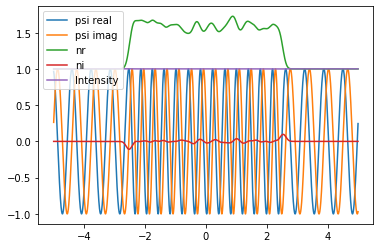

In [17]:
plot_psi(x, dx, n, 1, k)

### Berechne Abweichung von konstanter Intensität

In [18]:
def MSE(Int, Amp):
    return sum((Int-Amp)**2)

In [19]:
Amp = 1

n = n_compl(W,dW,x,k)
psi_r0, psi_r1, psi_i0, psi_i1 = InitV_In(x,dx,k, Amp)
psi = Numerov(x, dx, n, psi_r0, psi_r1, psi_i0, psi_i1, k)
Int = psi.real**2 + psi.imag**2

MSE(Int,Amp)

0.004989221342788703

### Daten generieren

Wir generieren und speichern eine Menge an $n_r$ und $n_i$ Paaren.

In [20]:
#so wurde das Dataset1, in dem verschiedene k Werte vorkommen, generiert!
out = 'data/'

x = np.arange(-5,5,0.001)
dx = x[1] - x[0]

size = 5000

In [ ]:
#so wurde das Dataset1, in dem verschiedene k Werte vorkommen, generiert!
Potentials = {}
Potentials['idx'] = []
Potentials['k'] = []

start = time.time()
last = time.time()

for i in range(size):

    if i%100 == 0: 
        so_far = time.time() - start
        since_last = time.time() - last
        last = time.time()
        print('Generating Pot Nmbr ',i, ', Runtime since last: ', since_last, ', Runtime so far: ', so_far)
        
    
    k = np.random.randint(1,11, size=1)[0]
    
    W = generate_W(x)
    dW = diff_W(W)
    
    n = n_compl(W,dW,x,k)
    
    np.save(out + 'n_real_' + str(i), n.real)
    np.save(out + 'n_imag_' + str(i), n.imag)
    Potentials['idx'].append(i)
    Potentials['k'].append(k)
    
df = pd.DataFrame(Potentials, columns= ['idx', 'k'])

export_csv = df.to_csv (r''+out+'k_values.csv', index = None, header=True)

df.head()

In [ ]:
#so wurde das Dataset2, in dem nur ein k Werte vorkommt, generiert!
out = 'data2/'

sample_length = 2**13
low = -5
up = 5
dx = (up-low)/sample_length
x = np.arange(low,up,dx)

size = int(len(x)/2)

In [ ]:
#so wurde das Dataset2, in dem nur ein k Werte vorkommt, generiert!
Potentials = {}
Potentials['idx'] = []
Potentials['k'] = []

start = time.time()
last = time.time()

for i in range(size):

    if i%100 == 0: 
        so_far = time.time() - start
        since_last = time.time() - last
        last = time.time()
        print('Generating Pot Nmbr ',i, ', Runtime since last: ', since_last, ', Runtime so far: ', so_far)
        
    
    k = 1 #np.random.randint(1,11, size=1)[0]
    
    W = generate_W(x)
    dW = diff_W(W)
    
    n = n_compl(W,dW,x,k)
    
    np.save(out + 'n_real_' + str(i), n.real)
    np.save(out + 'n_imag_' + str(i), n.imag)
    Potentials['idx'].append(i)
    Potentials['k'].append(k)
    
df = pd.DataFrame(Potentials, columns= ['idx', 'k'])

export_csv = df.to_csv (r''+out+'k_values.csv', index = None, header=True)

df.head()

3202


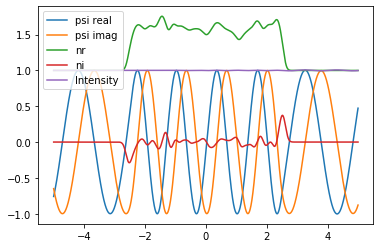

In [21]:
#test ob es funktioniert hat

df = pd.read_csv(out + '/k_values.csv')

idx = np.random.randint(size, size=1)[0]
print(idx)

k = df['k'][idx]

nr = np.load(out + 'n_real_' + str(idx) + '.npy')
ni = np.load(out + 'n_imag_' + str(idx) +'.npy')
n = nr + 1j*ni
plot_psi(x, dx, n, 1, k)

Ein Element aus unserem Dataset wird ein Dictionary sein, mit folgenden Werten:

    {
    'k_n_r': 1_dim Array (k, n_r),
    'n_i': 1_dim Array
    }

Wir erzeugen eine Klasse, von der ein Dataset ein Objekt sein wird. 

In [22]:
class PotentialDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform=None):
        self.k_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.k_frame)
    
    def __getitem__(self, idx):
        nr = np.load(out + 'n_real_' + str(idx) +'.npy')
        ni = np.load(out + 'n_imag_' + str(idx) +'.npy')
        k = self.k_frame['k'][idx]
        
        k_nr = np.append(k,nr)
        
        sample = {'k_n_r': k_nr, 
                  'n_i': ni}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [23]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        k_nr, ni = sample['k_n_r'], sample['n_i']
        
        return {'k_n_r': torch.from_numpy(k_nr).float().to(device),
                'n_i': torch.from_numpy(ni).float().to(device)}

In [24]:
class OneChannel(object):
    """For Convolution, size (N,C,L) is needed"""
    
    def __call__(self, sample):
        new_samp = {'k_n_r': torch.ones([1,len(sample['k_n_r'])]),
                    'n_i': torch.ones([1,len(sample['n_i'])])}
        new_samp['k_n_r'][0] = sample['k_n_r']
        new_samp['n_i'][0] = sample['n_i']
        new_samp['k_n_r'] = new_samp['k_n_r'].to(device)
        new_samp['n_i'] = new_samp['n_i'].to(device)
        
        return new_samp

In [25]:
class Normalize(object):
    """"Data ist then normalized to given mean and std."""

    def __init__(self, means, stds):
        self.nr_mean = means[0]
        self.nr_std = stds[0]
        self.ni_mean = means[1]
        self.ni_std = stds[1]
    
    def __call__(self, sample):
        k_nr, ni = sample['k_n_r'], sample['n_i']
        
        k_nr = (k_nr - self.nr_mean)/self.nr_std
        ni = (ni - self.ni_mean)/self.ni_std
        
        return {'k_n_r': k_nr,
                'n_i': ni}

Erzeuge das Objekt Dataset.

In [26]:
# calculate mean and std of data (vernachlässige k)

nr_mean = 0
nr_std = 0
ni_mean = 0
ni_std = 0

for i in range(size):
    nr = np.load(out + 'n_real_' + str(i) + '.npy')
    ni = np.load(out + 'n_imag_' + str(i) + '.npy')
    
    nr_mean += np.mean(nr)
    nr_std += np.std(nr)
    ni_mean += np.mean(ni)
    ni_std += np.std(ni)
    
nr_mean = nr_mean/size
nr_std = nr_std/size
ni_mean = ni_mean/size
ni_std = ni_std/size

In [27]:
transform = transforms.Compose([Normalize((nr_mean, ni_mean), (nr_std, ni_std)),
                                ToTensor(),
                                OneChannel()
                               ])

Lege Tensoren auf CUDA.

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
pot_dataset = PotentialDataset(csv_file = out + 'k_values.csv', 
                               root_dir = out,
                               transform = transform)

In [1]:
pot_dataset[19]['k_n_r'][0] #funktioniert prima

NameError: name 'pot_dataset' is not defined

In [31]:
print(pot_dataset[19]['k_n_r'].size())

torch.Size([1, 10001])


In [32]:
pot_dataset[19]['k_n_r'].is_cuda

True

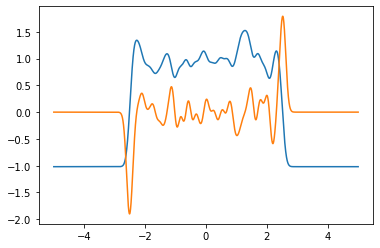

In [33]:
pylab.plot(x,pot_dataset[19]['k_n_r'][0].cpu().numpy()[1:])
pylab.plot(x,pot_dataset[19]['n_i'][0].cpu().numpy())

### Konstruiere Loader & Netz

Erstelle einen Train/Validation Split und die zugehörigen PyTorch DataLoader.

In [34]:
batch_size = 8
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(pot_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size)) #floor tut abrunden
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(pot_dataset, 
                          batch_size=batch_size, 
                          sampler=train_sampler)
validation_loader = DataLoader(pot_dataset, 
                               batch_size=batch_size,
                               sampler=valid_sampler)

Erstelle ein U-Net. Das sinnvoller als ein normales CNN, weil wieder ein Signal rekonstruiert werden muss und nicht nur klassifiziert.

In [35]:
#Das ist mein Netz!

LABEL_LEN = 10000 #leider hardgecodet aber wir brauchen diese global var im OUTCONV

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, 9, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, 9, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
         x = self.conv(x)
         return x        

class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x
        
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(            
            nn.MaxPool1d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x
    
class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose1d(in_ch, out_ch, 7, padding=1, stride=2),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True)    
        )
        self.conv = double_conv(in_ch, out_ch)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        #hier gibt es immer einen Padding Fehler, weil PyTorch kein SAME-Padding kennt
        diff = x2.size()[2] - x1.size()[2]

        x1 = F.pad(x1, (diff // 2, diff - diff//2)) #nur die letzte Dim wird gepadded
        
        x = torch.cat([x2, x1], dim = 1) #
        x = self.conv(x)
        return x        

class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, 50, 9, padding=3), #das padding wurde hier so gewählt, dass OUTPUT dem Label passt
            nn.BatchNorm1d(50),
            nn.ReLU(inplace=True),
            nn.Conv1d(50, out_ch, 1, padding=1)
        )

    def forward(self, x):
        
        #hier gibt es immer einen Padding Fehler, weil PyTorch kein SAME-Padding kennt
        diff = LABEL_LEN - x.size()[2]
        x = F.pad(x, (diff//2, diff-diff//2))
        
        x = self.conv(x)
        return x

In [36]:
#Das ist mein Netz!

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 128)
        self.down1 = down(128, 256)
        self.down2 = down(256, 512)
        self.down3 = down(512, 1024)
        self.down4 = down(1024, 2048)
        self.up1 = up(2048, 1024)
        self.up2 = up(1024, 512)
        self.up3 = up(512, 256)
        self.up4 = up(256, 128)
        self.outc = outconv(128, n_classes)

    def forward(self, x):
        #print('Size start: ', x.size())
        x1 = self.inc(x)
        #print('Size after INC: ', x1.size())
        x2 = self.down1(x1)
        #print('Size after DOWN1: ', x2.size())
        x3 = self.down2(x2)
        #print('Size after DOWN2: ', x3.size())
        x4 = self.down3(x3)
        #print('Size after DOWN3: ', x4.size())
        x5 = self.down4(x4)
        #print('Size after DOWN4: ', x5.size())
        x = self.up1(x5, x4)
        #print('Size after UP1: ', x.size())
        x = self.up2(x, x3)
        #print('Size after UP2: ', x.size())
        x = self.up3(x, x2)
        #print('Size after UP3: ', x.size())
        x = self.up4(x, x1)
        #print('Size after UP4: ', x.size())
        x = self.outc(x)
        #print('Size after OUTC: ', x.size())
        return x

In [ ]:
#sonst wird jetzt neues Model erstellt

model = UNet(n_channels=1, n_classes=1)
print(model)

### Lade Netz

In [37]:
#evtl soll nicht ein neues Model erstellt, sondern ein altes geladen werden!

PATH = 'run2/UNet_158_epoch.pt'

model = torch.load(PATH, map_location=device)
model.eval()

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv1d(1, 128, kernel_size=(9,), stride=(1,), padding=(1,))
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(1,))
        (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv1d(128, 256, kernel_size=(9,), stride=(1,), padding=(1,))
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
          (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(1,))
          (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, a

### Training

Model auf CUDA:

In [38]:
model.to(device)

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv1d(1, 128, kernel_size=(9,), stride=(1,), padding=(1,))
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(1,))
        (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv1d(128, 256, kernel_size=(9,), stride=(1,), padding=(1,))
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
          (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(1,))
          (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, a

In [39]:
next(model.parameters()).is_cuda

True

Definiere Optimizer und Loss Function und Learning rate.

In [ ]:
learning_rate = 1e-3

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Jetzt beginnt das echte Training.

In [ ]:
num_epochs = 300
train_loss = [] #Lists für Plot
validation_loss = []
PATH = 'models/UNet.pt'

# Initialisiere Visdom Loss Monitor
vis = visdom.Visdom()

#erste Punkte mit ursprünglichen Loss Werten
train_loss_ep = 0 
for i, data in enumerate(train_loader):
    k_nr = data['k_n_r']
    ni = data['n_i']
    ni_pred = model(k_nr)
    train_loss_ep += criterion(ni_pred,ni).item() / len(train_loader)
    
validation_loss_ep = 0
for i, data in enumerate(validation_loader):
    k_nr = data['k_n_r']
    ni = data['n_i']
    ni_pred = model(k_nr)
    validation_loss_ep += criterion(ni_pred,ni).item() / len(validation_loader)

#initialisiere die beiden Loss Lines in Visdom mit ersten Punkten
vis_loss_plt= vis.line(
    X=np.column_stack((0, 0)),
    Y=np.column_stack((train_loss_ep, validation_loss_ep)),
    opts = {
    'title': 'Loss Potential-Dataset',
    'legend': ['train','validation']}
)

#für early stopping
lowest_loss = (0, validation_loss_ep)
early_stopping_counter = 0

#fülle Listen für Matplolib Plot zum Schluss mit ersten Punkten
train_loss.append(train_loss_ep)
validation_loss.append(validation_loss_ep)

# Variablen für Zeit - Messung
ts = time.time()

#######################################################
# Ab hier bis zu Hashs geht das eigentliche Training!
#######################################################

running_loss = 0.0 #loss zum mitschreiben nach den Batches

for ep in range(num_epochs): #loop for some episodes
    
    model = model.train() #pytorch training mode
    
    for i, data in enumerate(train_loader): #iterate trough minibatches of training set
        
        k_nr = data['k_n_r']
        ni = data['n_i']
        
        # Forward pass: Compute predicted y by passing x to the model
        ni_pred = model(k_nr)

        # Compute and print loss
        loss = criterion(ni_pred, ni)

        # Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item() * k_nr.size(0)
        if i % 10 == 0:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f runtime: %f' %
                  (ep + 1, i + 1, running_loss / 10, time.time() - ts))
            running_loss = 0.0
            
#######################################################
# Ab jetzt nur mehr Plots etc
#######################################################  

    model = model.eval() #pytorch evaluation mode
    
    # print learning curve with visdom
    train_loss_ep = 0 #ermittle loss von gesamten train/val dataset
    for i, data in enumerate(train_loader):
        k_nr = data['k_n_r']
        ni = data['n_i']
        ni_pred = model(k_nr)
        train_loss_ep += criterion(ni_pred,ni).item() / len(train_loader)
    
    validation_loss_ep = 0
    for i, data in enumerate(validation_loader):
        k_nr = data['k_n_r']
        ni = data['n_i']
        ni_pred = model(k_nr)
        validation_loss_ep += criterion(ni_pred,ni).item() / len(validation_loader)
    
    #füge einen punkt in visdom hinzu
    vis.line(
        X=np.column_stack((ep+1, ep+1)),
        Y=np.column_stack((train_loss_ep,
                           validation_loss_ep )),
        win=vis_loss_plt,
        update='append'
    )
    
    # save losses for final loss plot
    train_loss.append(train_loss_ep)
    validation_loss.append(validation_loss_ep)
    
    #ealy stopping algorithm
    if validation_loss_ep < lowest_loss[1]:
        lowest_loss = (ep+1, validation_loss_ep)
        early_stopping_counter = 0
        torch.save(model, PATH)
    else:
        early_stopping_counter += 1
        
    if early_stopping_counter > 30:
        print('stopped after episode ', ep+1)
        print('lowest loss: ', lowest_loss[1])
        print('weights from episode ', lowest_loss[0])
        break

In [ ]:
# final loss plot
pylab.plot(train_loss,label='train')
pylab.plot(validation_loss,label='validation')
pylab.legend(loc='upper right')
pylab.show()

### Prüfe Predictions

Wir wollen noch für ein Objekt Prediction vs Label plotten.

In [40]:
#Rücktrafo weil Daten ja normalisiert sind

def DeNorm(x,mean,std):
    y = x*std + mean
    return y

Wir wollen alles für das Model mit dem niedrigsten Loss.

In [ ]:
PATH = 'models/UNet.pt'

model = torch.load(PATH)
model.eval()

4.999999916537538


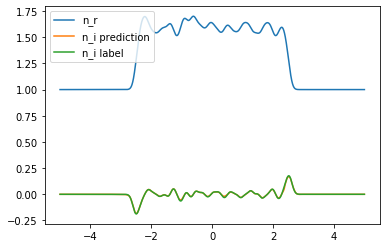

In [146]:
dataiter = iter(validation_loader)
item = dataiter.next()

k_nr = item['k_n_r'][0][0]
k = DeNorm(k_nr[0].cpu().numpy(), nr_mean, nr_std)

nr = k_nr[1:].cpu().numpy()
nr = DeNorm(nr, nr_mean, nr_std)
ni = item['n_i'][0].cpu().numpy()
ni = DeNorm(ni, ni_mean, ni_std)[0]

ni_pred = model(item['k_n_r']).detach().cpu().numpy()[0,0]
ni_pred = DeNorm(ni_pred, ni_mean, ni_std)

print(k) #höherer k Value führt zu kleinerem Peak von ni

pylab.plot(x,nr,label='n_r')
pylab.plot(x,ni_pred,label='n_i prediction')
pylab.plot(x,ni,label='n_i label')
pylab.legend(loc='upper left')
pylab.savefig('UNet Prediction.pdf')

Plotte jetzt noch die Wellen vom besten Model.

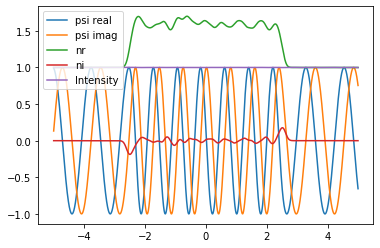

In [147]:
n = nr + 1j*ni

Int = plot_psi(x, dx, n, 1, k) # Amplitude = 1

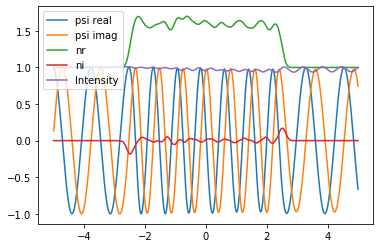

In [148]:
n_pred = nr + 1j*ni_pred

Int_pred = plot_psi(x, dx, n_pred, 1, k)
pylab.savefig('UNet CI.pdf')

Die Differenzen sehen so aus:

In [149]:
def deriv(y):
    dy = np.diff(y)/dx
    return np.concatenate((np.zeros(1), dy), axis=None)

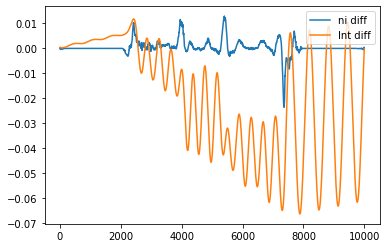

In [151]:
pylab.plot(ni_pred-ni, label = 'ni diff')
pylab.plot(Int_pred - Int, label = 'Int diff')
pylab.legend(loc='upper right')

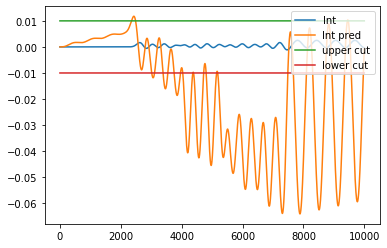

In [152]:
pylab.plot(Int -1, label = 'Int')
pylab.plot(Int_pred -1, label = 'Int pred')
pylab.plot(0.010*np.ones(len(ni)), label = 'upper cut')
pylab.plot(-0.010*np.ones(len(ni)), label = 'lower cut')
pylab.legend(loc='upper right')

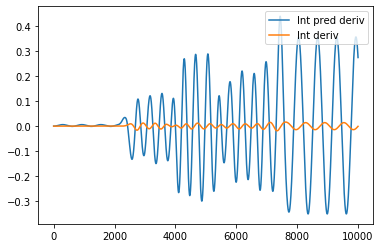

In [153]:
pylab.plot(deriv(Int_pred -1), label = 'Int pred deriv')
pylab.plot(deriv(Int -1), label = 'Int deriv')
pylab.legend(loc='upper right')

Schwingung rausmitteln.

In [154]:
def moving_average(a, n=int(np.pi/k/dx)) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

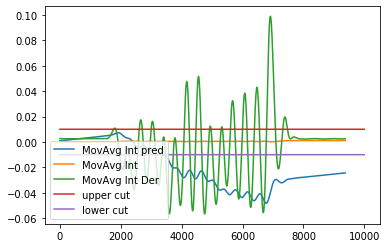

In [155]:
pylab.plot(moving_average(Int_pred -1), label = 'MovAvg Int pred')
pylab.plot(moving_average(Int -1), label = 'MovAvg Int')
pylab.plot(moving_average(deriv(Int_pred -1)), label = 'MovAvg Int Der')
pylab.plot(0.010*np.ones(len(ni)), label = 'upper cut')
pylab.plot(-0.010*np.ones(len(ni)), label = 'lower cut')
pylab.legend(loc='lower left')

### Kann Model Unterschied sehen?

In [171]:
def get_Int(x, dx, item, idx, Amp=1):

    k_nr = item['k_n_r'][idx][0]
    k = DeNorm(k_nr[idx].cpu().numpy(), nr_mean, nr_std)
    
    nr = k_nr[1:].cpu().numpy()
    nr = DeNorm(nr, nr_mean, nr_std)
    ni = item['n_i'][idx].cpu().numpy()
    ni = DeNorm(ni, ni_mean, ni_std)[0]
    
    n = nr + 1j*ni
    
    Int = plot_psi(x, dx, n, 1, k)
    
    return Int

In [ ]:
# erstelle Datenset für Corrector

data2_path = 'data2/'

for i, data in enumerate(train_loader):
    k_nr = data['k_n_r']
    ni = data['n_i']
    ni_pred = model(k_nr)
    for j in range(batch_size):
        torch.save(k_nr[j], data2_path + 'knr_train_' + str(i) + '_' + str(j) + '.pt')
        torch.save(ni[j], data2_path + 'ni_train_' + str(i) + '_' + str(j) + '.pt')
        torch.save(ni_pred[j], data2_path + 'ni_pred_train_' + str(i) + '_' + str(j) + '.pt')  
        torch.save(torch.from_numpy(get_Int(x, dx, data, j)), 
                   data2_path + 'I_pred_train_' + str(i) + '_' + str(j) + '.pt')
    print('Saved Train Batch ', i)
        
for i, data in enumerate(validation_loader):
    k_nr = data['k_n_r']
    ni = data['n_i']
    ni_pred = model(k_nr)
    for j in range(batch_size):
        torch.save(k_nr[j], data2_path + 'knr_validation_' + str(i) + '_' + str(j) + '.pt')
        torch.save(ni[j], data2_path + 'ni_validation_' + str(i) + '_' + str(j) + '.pt')
        torch.save(torch.from_numpy(get_Int(x, dx, data, j)), 
                   data2_path + 'I_pred_validation_' + str(i) + '_' + str(j) + '.pt')  
    print('Saved Validation Batch ', i)

Saved Train Batch  0
Saved Train Batch  1
Saved Train Batch  2
Saved Train Batch  3
Saved Train Batch  4
Saved Train Batch  5
Saved Train Batch  6
Saved Train Batch  7
Saved Train Batch  8
Saved Train Batch  9
Saved Train Batch  10
Saved Train Batch  11
Saved Train Batch  12
Saved Train Batch  13
Saved Train Batch  14
Saved Train Batch  15
Saved Train Batch  16
Saved Train Batch  17
Saved Train Batch  18
Saved Train Batch  19
Saved Train Batch  20
Saved Train Batch  21
Saved Train Batch  22
Saved Train Batch  23
Saved Train Batch  24
Saved Train Batch  25
Saved Train Batch  26
Saved Train Batch  27
Saved Train Batch  28
Saved Train Batch  29
Saved Train Batch  30
Saved Train Batch  31
Saved Train Batch  32
Saved Train Batch  33
Saved Train Batch  34
Saved Train Batch  35
Saved Train Batch  36
Saved Train Batch  37
Saved Train Batch  38
Saved Train Batch  39
Saved Train Batch  40
Saved Train Batch  41
Saved Train Batch  42
Saved Train Batch  43
Saved Train Batch  44
Saved Train Batch  4

### Save Model

In [ ]:
PATH = 'models/UNet.pt'

torch.save(model, PATH)

### Nützliches eventuell für Später


Außerdem wollen wir den MSE brechnen, wie sehr n_i und die prediction punktweise abweichen und die Prediction dann als "richtig" oder "falsch" detulieren. 

In [ ]:
def MSE_Difference(ni,ni_pred):
    if len(ni) != len (ni_pred):
        print('label and prediction must have same size!')
    else:
        err = 0
        for (i,j) in zip(ni, ni_pred):
            err += (i-j)**2
        err = err/len(ni)
        return err

In [ ]:
MSE_Difference(ni, ni_pred)

Und hier soll noch der MSE der resultierenden Welle berechnet werden und die Welle geplottet. Der MSE sollte jedenfalls kleiner 1 sein, wenn die prediction korrekt ist.

In [ ]:
# hier ein Test, wie hoch der MSE ist für leicht verrauschte Daten
# mt einem MSE von 0.02 muss man scheinbar immer rechnen


ni_noise = np.copy(ni.detach().numpy())
noise_range = 0.5
for i in range(len(ni_noise)):
    ni_noise[i] +=  np.random.uniform()*noise_range - noise_range/2

pylab.plot(x,ni_noise,label='n_i prediction')
pylab.plot(x,ni.numpy(),label='n_i label')
pylab.legend(loc='upper left')
pylab.show()
MSE_Difference(ni.detach().numpy(), ni_noise)

In [ ]:
#Fourier transformiere n

def FFT_n(n,x):
    nrf = 2.0/len(x) * np.abs(fft(n.real)[0:len(x)//2])
    nif = 2.0/len(x) * np.abs(fft(n.imag)[0:len(x)//2])
    xf = np.linspace(0.0, 1.0/(2.0*dx), len(x)//2)
    return nrf, nif, xf

In [ ]:
#spectrogram plot von n

fs = 10/len(x)

f, t, Sxx = signal.spectrogram(n.real, fs)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()